# Rotten Tomatoes movie review - Weekly Project

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis

This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: 
- negative
- somewhat negative
- neutral
- somewhat positive
- positive. 

Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
import unicodedata


In [2]:
from bs4 import BeautifulSoup

from collections import Counter
from matplotlib import pyplot
from numpy import where

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head(10)

,Unnamed: 0,PhraseId,SentenceId,Phrase,Sentiment
0,0,122,4,positively,3
1,1,19366,851,disguise the slack complacency of -LRB- Godard...,1
2,2,54763,2726,realizes a fullness that does not negate the s...,3
3,3,89708,4667,sealed,2
4,4,33494,1571,Go Where We Went 8 Movies Ago,3
5,5,146330,7957,the thin soup,2
6,6,62064,3138,keeps the energy humming,3
7,7,123644,6640,the most poorly staged and lit action in memory,0
8,8,89875,4677,a $ 40 million version,2
9,9,80766,4162,"putting together familiar themes of family , f...",3


In [5]:
#drop duplicate
df = df.drop_duplicates()

#check null data
df.isnull().sum()

Unnamed: 0    0
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [6]:
df['word_count'] = df['Phrase'].str.split(' ').str.len()

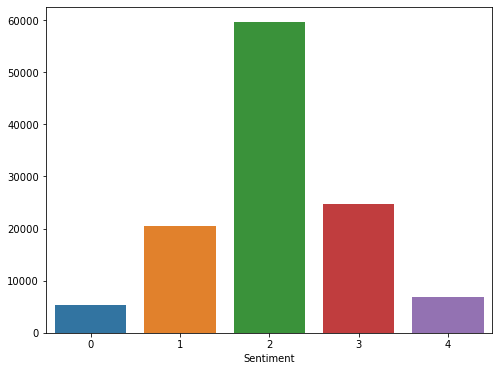

In [7]:
#check unique sentiment label
df['Sentiment'].unique()

#array([3, 1, 2, 0, 4], dtype=int64)
#0 - most negative
#1 - somewhat negative
#2 - neutral
#3 - somewhat postive
#4 - most positive

#check distribution of sentiment
dist = df.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(dist.keys(), dist.values);

In [8]:
#use this to determine class for each sentiment
#since neutral tone is the most occured one, use it as the nominator i.e. Wi = ni / n2

weight = {0: dist[2]/dist[0],
         1: dist[2]/dist[1],
         2: dist[2]/dist[2],
         3: dist[2]/dist[3],
         4: dist[2]/dist[4]}
weight

{0: 11.346849419379403,
 1: 2.8986529202937317,
 2: 1.0,
 3: 2.405561385099685,
 4: 8.706543967280163}

In [9]:
#dictionary for stop words
stop_words = stopwords.words('english')

#dictionary of lematising words
lemmatizer = WordNetLemmatizer()

#dictionary of stemming words
porter = PorterStemmer()

In [10]:
#Preprocessing words
def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = BeautifulSoup(text, "lxml").text
    
    # Remove non-ASCII characters 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #get only letters
    text = re.sub("[^a-zA-Z]"," ",text)
    
    #lower case and split
    text = text.lower().split()
    
    #remove stop words
#     stops = set(stopwords.words("english")) #faster to search through a set than a list
#     text = [ w for w in text if not w in stop_words]  
    
    #lemmatising
    text = [lemmatizer.lemmatize(w) for w in text]
    
    #steming words
    text = [porter.stem(w) for w in text]        
    
    #join words
    text = " ".join(text)
    return text

preprocessor("Hi there, I am loving  this, like with 234a& lot of love. He loves it too@~@>: @A:>S")
preprocessor("This is not bad at all 079 ^$>>")

'thi is not bad at all'

In [16]:
df.loc[df['Sentiment'] <= 2, 'group_sentiment'] = 0
df.loc[df['Sentiment'] >2, 'group_sentiment'] = 1

df_pos = df.loc[df['group_sentiment'] == 1]

TRAIN GROUP SENTIMENT 0 - Negative and 1 - Positive

In [59]:
#determine X and y accordingly 
#X = df['Phrase']
#y = df['Sentiment']

X = df['Phrase']
y = df['group_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)
X_test.shape

(23409,)

In [60]:
#TRAIN CLASSIFIER BASED ON GROUP SENTIMENT

#vertorise data with features

#countvectorizer emphasises on the frequency of occurence of the words
#which is more suitable for a sentimental training
count = CountVectorizer(input='content', 
                                   encoding='utf-8', 
                                   decode_error='strict', 
                                   strip_accents=None, 
                                   lowercase=True, 
                                   preprocessor=preprocessor, 
                                   tokenizer=word_tokenize, 
                                   stop_words=None, 
                                   token_pattern='(?u)\b\w\w+\b', 
                                   ngram_range=(1, 2), 
                                   analyzer='word', 
                                   max_df=1.0, 
                                   min_df=1, 
                                   max_features=None, 
                                   vocabulary=None, 
                                   binary=True, 
                                   dtype=np.float64)

logistic_regression = LogisticRegression(penalty='l2', 
                                         dual=False, 
                                         tol=0.000001, 
                                         C=1.0, 
                                         fit_intercept=True, 
                                         intercept_scaling=1, 
                                         class_weight=None,#weight, 
                                         random_state=102, 
                                         solver='lbfgs', 
                                         max_iter=100000, 
                                         multi_class='multinomial', 
                                         verbose=0, 
                                         warm_start=True, 
                                         n_jobs=None, 
                                         l1_ratio=None)

# A pipeline is what chains several steps together, once the initial exploration is done. 
# For example, some codes are meant to transform features — normalise numericals, or turn text into vectors, 
# or fill up missing data, they are transformers; other codes are meant to predict variables by fitting an algorithm,
# they are estimators. Pipeline chains all these together which can then be applied to training data
clf_group = Pipeline([('vect', count),
                ('clf', LogisticRegression())])

In [61]:
clf_group.fit(X_train, y_train)

C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('vect',
                 CountVectorizer(binary=True, dtype=<class 'numpy.float64'>,
                                 ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x000001F6FDBCAD38>,
                                 token_pattern='(?u)\x08\\w\\w+\x08',
                                 tokenizer=<function word_tokenize at 0x000001F6FAB208B8>)),
                ('clf', LogisticRegression())])

In [62]:
#Test prediction
predictions = clf_group.predict(X_test)

C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [22]:
#Evaluate
print('accuracy:',accuracy_score(y_test,predictions))
print('confusion matrix:\n',confusion_matrix(y_test,predictions))
print('classification report:\n',classification_report(y_test,predictions))

accuracy: 0.8696227946516297
confusion matrix:
 [[16166   894]
 [ 2158  4191]]
classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     17060
         1.0       0.82      0.66      0.73      6349

    accuracy                           0.87     23409
   macro avg       0.85      0.80      0.82     23409
weighted avg       0.87      0.87      0.86     23409



Text(0.5, 15.0, 'Predicted label')

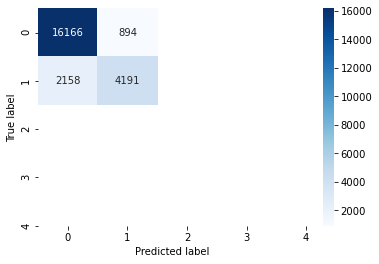

In [23]:
cm = confusion_matrix(y_test, predictions)
# view with a heatmap
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues', xticklabels=['0', '1','2','3','4'], yticklabels=['0', '1','2','3','4'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

TRAIN NEG-GROUP SENTIMENT 0 - 1 -2

In [41]:
#determine X and y accordingly 
df_neg = df.loc[df['group_sentiment'] == 0]

X = df_neg['Phrase']
y = df_neg['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

In [42]:
clf_neg = Pipeline([('vect', count),
                ('clf', LogisticRegression())])

In [43]:
clf_neg.fit(X_train, y_train)

C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

Pipeline(steps=[('vect',
                 CountVectorizer(binary=True, dtype=<class 'numpy.float64'>,
                                 ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x000001F6FDBCAD38>,
                                 token_pattern='(?u)\x08\\w\\w+\x08',
                                 tokenizer=<function word_tokenize at 0x000001F6FAB208B8>)),
                ('clf', LogisticRegression())])

In [44]:
predictions = clf_neg.predict(X_test)

In [45]:
#Evaluate
print('accuracy:',accuracy_score(y_test,predictions))
print('confusion matrix:\n',confusion_matrix(y_test,predictions))
print('classification report:\n',classification_report(y_test,predictions))

accuracy: 0.7774070822358794
confusion matrix:
 [[  361   522   157]
 [  282  1941  1893]
 [   71   878 10980]]
classification report:
               precision    recall  f1-score   support

           0       0.51      0.35      0.41      1040
           1       0.58      0.47      0.52      4116
           2       0.84      0.92      0.88     11929

    accuracy                           0.78     17085
   macro avg       0.64      0.58      0.60     17085
weighted avg       0.76      0.78      0.76     17085



Text(0.5, 15.0, 'Predicted label')

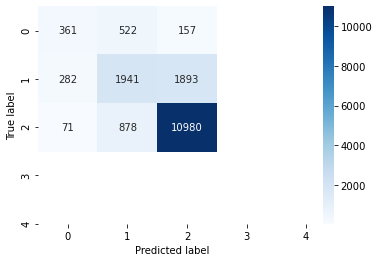

In [46]:
cm = confusion_matrix(y_test, predictions)
# view with a heatmap
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues', xticklabels=['0', '1','2','3','4'], yticklabels=['0', '1','2','3','4'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

TRAIN POS-GROUP SENTIMENT 3 - 4

In [50]:
#determine X and y accordingly 
df_pos = df[df['group_sentiment'] == 1]

X = df_pos['Phrase']
y = df_pos['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

In [51]:
clf_pos = Pipeline([('vect', count),
                ('clf', LogisticRegression())])

In [52]:
clf_pos.fit(X_train, y_train)

C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('vect',
                 CountVectorizer(binary=True, dtype=<class 'numpy.float64'>,
                                 ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x000001F6FDBCAD38>,
                                 token_pattern='(?u)\x08\\w\\w+\x08',
                                 tokenizer=<function word_tokenize at 0x000001F6FAB208B8>)),
                ('clf', LogisticRegression())])

In [53]:
predictions = clf_pos.predict(X_test)

In [54]:
#Evaluate
print('accuracy:',accuracy_score(y_test,predictions))
print('confusion matrix:\n',confusion_matrix(y_test,predictions))
print('classification report:\n',classification_report(y_test,predictions))

accuracy: 0.8172332015810276
confusion matrix:
 [[4631  368]
 [ 788  538]]
classification report:
               precision    recall  f1-score   support

           3       0.85      0.93      0.89      4999
           4       0.59      0.41      0.48      1326

    accuracy                           0.82      6325
   macro avg       0.72      0.67      0.69      6325
weighted avg       0.80      0.82      0.80      6325



Text(0.5, 15.0, 'Predicted label')

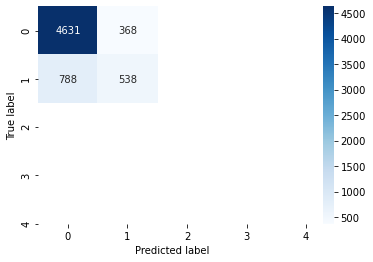

In [55]:
cm = confusion_matrix(y_test, predictions)
# view with a heatmap
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues', xticklabels=['0', '1','2','3','4'], yticklabels=['0', '1','2','3','4'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [63]:
#COMBINE clf_group, clf_neg and clf_neg

X = df['Phrase']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

df_guess = pd.concat([X_test, y_test], axis=1)
df_guess

In [76]:
group_preds = clf_group.predict(X_test)

C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [78]:
df_guess['guess_group_sentiment'] = group_preds
df_guess

,Phrase,Sentiment,guess_group_sentiment
2647,"Khouri manages , with terrific flair , to keep...",3,1.0
113343,a small film,2,0.0
10165,Tykwer 's,2,0.0
67220,bankruptcy,1,0.0
79389,their working-class subjects,2,0.0
...,...,...,...
58347,appears miserable throughout as he swaggers th...,1,0.0
63896,urgent,2,0.0
33443,as much as 8 Women 's Augustine,2,0.0
41963,have anything really interesting to say,2,0.0


In [79]:
X_neg = df_guess.loc[df_guess['guess_group_sentiment'] == 0]
X_pos = df_guess.loc[df_guess['guess_group_sentiment'] == 1]

In [81]:
neg_preds = clf_neg.predict(X_neg)
pos_preds = clf_pos.predict(X_pos)

ValueError: X has 51496 features per sample; expecting 71934

In [271]:
#dump into an pickle file to read and run later
pickle.dump(clf, open('review_logistic_regression_count_ngram12.pkl', 'wb'))

In [12]:
#read pickle file model
with open('review_logistic_regression_count_ngram12.pkl', 'rb') as model:
    reload_model = pickle.load(model)
    

In [13]:
#read test.csv file and make prediction
df_test_unlabel = pd.read_csv('test.csv')
X_test_unlabel = df_test_unlabel['Phrase']

preds = reload_model.predict(X_test_unlabel)


In [102]:
#save to submission.csv file
df_test_unlabel['Sentiment'] = preds
df_test_unlabel.to_csv('./submission.csv', index=False)